In [1]:
import wbgapi as wb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Obtener información de indicadores
wb.series.info(q = "life")

id,value
SH.MMR.RISK,Lifetime risk of maternal death (1 in: rate varies by country)
SH.MMR.RISK.ZS,Lifetime risk of maternal death (%)
SP.DYN.LE00.FE.IN,"Life expectancy at birth, female (years)"
SP.DYN.LE00.IN,"Life expectancy at birth, total (years)"
SP.DYN.LE00.MA.IN,"Life expectancy at birth, male (years)"
,5 elements


In [5]:
## Revisamos qué otros indicadores hay en wb:

all_series = wb.series.list()

filter_name = '' ## Creo un filtro para poder chequear según conceptos que puedan ser relevantes.

filtered_series = [series for series in all_series if filter_name in series['value']]

for series in filtered_series:
    print(f"{series['id']}: {series['value']}")

## Incluimos al menos dos variables que puedan ser relevantes:

    ## SH.XPD.CHEX.PC.CD: Current health expenditure per capita (current US$) - el gasto en salud debiera impactar en una mayor esperanza de vida por una mejor calidad de la salud.
    ## VC.IHR.PSRC.P5: Intentional homicides (per 100,000 people) - la cantidad de homicidios debiera estar relacionado con una menor esperanza de vida.

AG.CON.FERT.PT.ZS: Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS: Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2: Agricultural land (sq. km)
AG.LND.AGRI.ZS: Agricultural land (% of land area)
AG.LND.ARBL.HA: Arable land (hectares)
AG.LND.ARBL.HA.PC: Arable land (hectares per person)
AG.LND.ARBL.ZS: Arable land (% of land area)
AG.LND.CREL.HA: Land under cereal production (hectares)
AG.LND.CROP.ZS: Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2: Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS: Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.EL5M.UR.K2: Urban land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.UR.ZS: Urban land area where elevation is below 5 meters (% of total land area)
AG.LND.EL5M.ZS: Land area where elevation is below 5 meters (% of total land area)
AG.LND.FRST.K2: Forest area (sq. km)
AG.LND.FRST.ZS: Forest area (% of land area)
AG.LND.

In [7]:
## Indicadores: PIB, Población y Tasa de mortalidad infantil
indicadores = ["NY.GDP.MKTP.CD",  # PIB (USD)
               "SP.POP.TOTL",      # Población total
               "SP.DYN.IMRT.IN"   # Tasa de mortalidad infantil (por 1,000 nacidos vivos)
               "NY.GDP.PCAP.CD",     # PIB per cápita (USD)
               "SP.URB.TOTL.IN.ZS",  # Población urbana (% del total)
               "SP.DYN.LE00.IN",      # Esperanza de vida al nacer (años),
               "SH.XPD.CHEX.PC.CD", # Current health expenditure per capita (current US$),
               "VC.IHR.PSRC.P5", #Intentional homicides (per 100,000 people)
              ]

## Descargar datos para el periodo 2010-2020
datos_wb = wb.data.DataFrame(indicadores, time=range(2010, 2021), labels=True)

In [9]:
## Pivotear la tabla para tener los años como filas en lugar de columnas
datos_wb = datos_wb.melt(id_vars=["Country", "Series"], var_name="year", value_name="value")

In [11]:
## Pivotear las series para que cada indicador sea una columna
datos_wb_pivot = datos_wb.pivot_table(index=["Country", "year"], columns="Series", values="value").reset_index()

In [13]:
## Inspeccionar
datos_wb_pivot.head()

Series,Country,year,Current health expenditure per capita (current US$),GDP (current US$),"Intentional homicides (per 100,000 people)","Life expectancy at birth, total (years)","Population, total",Urban population (% of total population)
0,Afghanistan,YR2010,46.579880,1.585667e+10,3.487093,60.851,28189672.0,23.737
1,Afghanistan,YR2011,52.363049,1.780510e+10,4.208668,61.419,29249157.0,23.948
2,Afghanistan,YR2012,52.613541,1.990733e+10,6.393913,61.923,30466479.0,24.160
3,Afghanistan,YR2013,56.305542,2.014642e+10,NaN,62.417,31541209.0,24.373
4,Afghanistan,YR2014,60.189579,2.049713e+10,NaN,62.545,32716210.0,24.587


In [15]:
## Renombrar las columnas para que sean más legibles
datos_wb_pivot.columns = ["country", "year", "health_expend", "gdp", "homicides", "life_exp", "population", "urban_pop"]

In [19]:
## Arreglamos la columna año porque el formato no es cómodo:

datos_wb_pivot['year'] = datos_wb_pivot['year'].str.replace('YR', '', regex=False)

In [21]:
## Inspeccionar
datos_wb_pivot.head()

,country,year,health_expend,gdp,homicides,life_exp,population,urban_pop
0,Afghanistan,2010,46.579880,1.585667e+10,3.487093,60.851,28189672.0,23.737
1,Afghanistan,2011,52.363049,1.780510e+10,4.208668,61.419,29249157.0,23.948
2,Afghanistan,2012,52.613541,1.990733e+10,6.393913,61.923,30466479.0,24.160
3,Afghanistan,2013,56.305542,2.014642e+10,NaN,62.417,31541209.0,24.373
4,Afghanistan,2014,60.189579,2.049713e+10,NaN,62.545,32716210.0,24.587


In [23]:
## Revisamos cuantos NAs hay en la data:

missing_values = datos_wb_pivot.isnull().sum()
print(missing_values)

country             0
year                0
health_expend     335
gdp                71
homicides        1173
life_exp           80
population          0
urban_pop          22
dtype: int64


In [25]:
## Cómo son muchos casos perdidos, imputamos usando interpolación, dados que son series de tiempo:

numeric_columns = datos_wb_pivot.select_dtypes(include=['number'])

datos_wb_pivot[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.mean())

In [27]:
missing_values = datos_wb_pivot.isnull().sum()
print(missing_values)

country          0
year             0
health_expend    0
gdp              0
homicides        0
life_exp         0
population       0
urban_pop        0
dtype: int64


In [29]:
X_1 = datos_wb_pivot.filter(items=[
    "gdp", 
    "population", 
    "urban_pop",
    "health_expend",
    "homicide"
])
y_1 = datos_wb_pivot["life_exp"]

In [31]:
## Definir preprocesamiento.

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_1)
categorical_columns = categorical_columns_selector(X_1)

In [33]:
from sklearn.preprocessing import OneHotEncoder
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [35]:
## Dividir los datos en conjuntos de entrenamiento y prueba
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=86)

In [53]:
## Crear el pipeline de preprocesamiento y modelo
pipeline = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=500, random_state=86))
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['gdp', 'population',
                                                   'urban_pop',
                                                   'health_expend'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, random_state=86))])

In [55]:
# Ajustar el modelo
forest_1 = pipeline.fit(X_1_train, y_1_train)

forest_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['gdp', 'population',
                                                   'urban_pop',
                                                   'health_expend'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, random_state=86))])

## Métricas de calidad:

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_1_pred = forest_1.predict(X_1_test)

mae = mean_absolute_error(y_1_test, y_1_pred)
mse = mean_squared_error(y_1_test, y_1_pred)
rmse = mean_squared_error(y_1_test, y_1_pred, squared=False)
r2 = r2_score(y_1_test, y_1_pred)

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

## Valor R cuadrado es adecuado.

Mean Absolute Error (MAE): 1.0827103760197407
Mean Squared Error (MSE): 4.95967519846295
Root Mean Squared Error (RMSE): 2.227032823840491
R² Score: 0.9133030306830692


C:\Users\nando\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Creación de un clasificador binario.

In [59]:
## Binarizamos la variable dependiente (y):

from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
y_1_train_class = discretizer.fit_transform(y_1_train.values.reshape(-1, 1)).astype(int).flatten()
y_1_test_class = discretizer.transform(y_1_test.values.reshape(-1, 1)).astype(int).flatten()

In [63]:
from sklearn.ensemble import RandomForestClassifier

pipeline_2 = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=500, random_state=86))
pipeline_2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['gdp', 'population',
                                                   'urban_pop',
                                                   'health_expend'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500, random_state=86))])

In [65]:
# Ajustar el modelo
forest_class_1 = pipeline_2.fit(X_1_train, y_1_train_class)

forest_class_1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['gdp', 'population',
                                                   'urban_pop',
                                                   'health_expend'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500, random_state=86))])

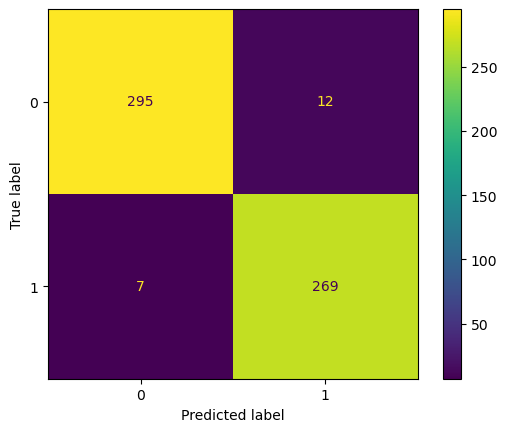

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

forest_class_1_matrix = ConfusionMatrixDisplay.from_estimator(forest_class_1, X_1_test, y_1_test_class)

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Función para imprimir métricas de clasificación
def print_classification_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("\n")

In [83]:
y_1_pred_forest_class_1 = forest_class_1.predict(X_1_test)
print_classification_metrics(y_1_test_class, y_1_pred_forest_class_1, "Modelo de Random Forest para Clasificación")

--- Modelo de Random Forest para Clasificación ---
Accuracy: 0.9674
Precision: 0.9676
Recall: 0.9674
F1-Score: 0.9674
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       307
           1       0.96      0.97      0.97       276

    accuracy                           0.97       583
   macro avg       0.97      0.97      0.97       583
weighted avg       0.97      0.97      0.97       583



